In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.2.1'

![alt text](figure/lec1_synthetic1.png)

使用r2rt博客的合成数据

In [3]:
# 设置合成数据的特征
total_size = 1000000

def gen_data(size=total_size):
    """ 按照上图生成合成序列数据
    
    Arguments:
        size: input 和 output 序列的总长度
    
    Returns:
        X, Y: input 和 output 序列，rank-1的numpy array （即，vector)
    """
    
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)


![alt text](figure/lec1_gen_batch.png)

In [4]:
# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    """产生minibatch数据
    
    Arguments:
        raw_data: 所有的数据， (input, output) tuple
        batch_size: 一个minibatch包含的样本数量；每个样本是一个sequence
        num_step: 每个sequence样本的长度
        
    Returns:
        一个generator，在一个tuple里面包含一个minibatch的输入，输出序列
    """
    
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Calculate the perplexity

1. **definition:**
  + Perplexity is an average statistical measure of probabilistic model.
  + Perplexity is the cross entropy of an true distribution of the data and the predicted distribution of the data (your model).In classification problem:
  $$ ppx =  \int_x \int_y P(x) P(y|x) \log P(y|x) dx dy$$
  + Empirically, this boils down to the average log likelihood. 
  $$ppx = - \frac{1}{N}\sum_{n=1}^{N} \log(P(y=y_n|x_n))$$
2. **probability of** $p(y_t = 1)$ **:**
  + with probability 0.25, $x_{t-3}=1, x_{t-8} = 1$, and $p(y_t=1|x_{t-3}=1, x_{t-8} = 1) = 0.75$
  + with probability 0.25, $x_{t-3}=1, x_{t-8} = 0$, and $p(y_t=1|x_{t-3}=1, x_{t-8} = 0) = 1$
  + with probability 0.25, $x_{t-3}=0, x_{t-8} = 1$, and $p(y_t=1|x_{t-3}=0, x_{t-8} = 1) = 0.25$
  + with probability 0.25, $x_{t-3}=0, x_{t-8} = 0$, and $p(y_t=1|x_{t-3}=0, x_{t-8} = 0) = 0.5$
  + with probability 0.5, $x_{t-3}=1, x_{t-8} = 1 or 0$, and $p(y_t=1|x_{t-3}=1) = [p(y_t=1|x_{t-3}=1, x_{t-8} = 1) + p(y_t=1|x_{t-3}=1, x_{t-8} = 0)]/2.0 = 0.875$
  + with probability 0.5, $x_{t-3}=0, x_{t-8} = 1 or 0$, and $p(y_t=1|x_{t-3}=1) = [p(y_t=1|x_{t-3}=0, x_{t-8} = 1) + p(y_t=1|x_{t-3}=0, x_{t-8} = 0)]/2.0 = 0.375$
  + 综上所述，$p(y=1) = 0.625$
3. **一个完全正确的模型** $P(y)$ **有 perplexity:**
$$ppx = - 0.25 \times [0.75 \times \log(0.75) + 0.25 \times \log(0.25)] - 0.25 \times [0.75 \times \log(0.75) + 0.25 \times \log(0.25)] - 0.25 \times [0 \times \log(0) + 1.0 \times \log(1.0)] - 0.25 \times [0.5 \times \log(0.5) + 0.5 \times \log(0.5)] \approx 0.454$$
**This is the smallest possible perplexity**
4. **完全不考虑时间线上的dependence的情况下** $P(y)$ **的perplexity:**
$$ppx = -0.5*[0.625 \times \log(0.625) + 0.375\times \log(0.375)]  -0.5*[0.875 \times \log(0.875) + 0.125\times \log(0.125)] \approx 0.519$$
5. **A partially correct model on** $y$ **has perplexity:**
$$ppx = -[0.25 \times \log(0.5) + 0.25\times \log(0.5) + 0.25 \times \log(0.5) + 0.25 \times \log(0.5)] \approx 0.693$$

![alt text](figure/lec1_synthetic1_rnn.png)

## 简易版RNN模型实现
1. 默认 `graph`, `variable_scope`, `name_scope`
2. 自定义rnn cell

**tensorflow tip: tf.placeholder**

1. 在计算图中添加node，用于存储数据
2. placeholder没有默认数据，数据完全由外部提供。注意tf.Variable, tf.Tensor和tf.placeholder的区别
  + 外界输入数据： tf.placeholder
  + 中间数据: tf.Tensor, tensorflow operation的output，
  + 参数: tf.Variable

In [5]:
"""
Placeholders
"""
tf.reset_default_graph()

batch_size = 32
num_steps = 4

x = tf.placeholder(tf.int32, [batch_size, num_steps],
                   name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps],
                   name='labels_placeholder')


In [6]:
"""
RNN Inputs， 将前面定义的placeholder输入到RNN cells
"""

# 将输入序列中的每一个0,1数字转化为二维one-hot向量
num_classes = 2
x_one_hot = tf.one_hot(x, num_classes) # [batch_size, num_steps，num_classes = 2]
rnn_inputs = tf.unstack(x_one_hot, axis=1) # [ num_steps, [batch_size, num_classes]]

![alt text](figure/official_basic_rnn.png)

## RNN参数的两点笔记

### 1. 初始化：
parameter initializer:
* xavier_initializer_conv2d
* variance_scaling_initializer
* constant_initializer
* zeros_initializer
* ones_initializer
* uniform_unit_scaling_initializer
* truncated_normal_initializer
* random_uniform_initializer
* **random_normal_initializer**
* orthogonal_initializer

根据Hinton教授的[A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
第8.1节
> Use small random values for the weights chosen from a zero-mean Gaussian with a standard deviation of 0.01. Set the hidden biases to 0. 

如果我们使用常用的random_normal_initializer, 设置stddev = 0.01, mean = 0

### 2. reuse variable scope：
RNN和其他典型的NN模型（例如视觉领域常用的DNN, CNN)不同之处在于，**有多个time frame的 RNN 单元共享同样的参数，所以需要小心 variable scope**

In [7]:
"""
手动实现 rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/python/ops/rnn_cell_impl.py#L232
（见上图）
"""

state_size = 16

with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size], 
                       initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.01))
    b = tf.get_variable('b', [state_size],
                        initializer = tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

# init_state, state 和 final_state:

In [8]:
"""
对每个time frame应用rnn
"""

rnn_outputs = []
init_state = tf.zeros([batch_size, state_size])

state = init_state
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)

final_state = rnn_outputs[-1]

In [9]:
"""
计算损失函数，定义优化器
"""
# 从每个 time frame 的 hidden state
# 映射到每个 time frame 的最终 output（prediction）；
# 和CBOW或者SKIP-GRAM的最上一层相同

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# 计算损失函数
y_as_list = tf.unstack(y, num=num_steps, axis=1)
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)

# 定义优化器
learning_rate = 0.1
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

**上面有一个tf.Variable**的例子

在**`tf.variable_scope('rnn_cell')`**和**`tf.variable_scope('softmax')`**中，各自有两个用W和b表示的`tf.Variable`. 因为在不同的variable_scope，即便使用同样的名字，表示的是不同的对象

如下面的代码所示：

In [10]:
# 本模型所有的variable：
all_vars = [node.name for node in tf.global_variables()]
for var in all_vars:
    print(var)

rnn_cell/W:0
rnn_cell/b:0
softmax/W:0
softmax/b:0
rnn_cell/W/Adagrad:0
rnn_cell/b/Adagrad:0
softmax/W/Adagrad:0
softmax/b/Adagrad:0


In [11]:
# 打印graph的nodes：
all_node_names = [node for node in tf.get_default_graph().as_graph_def().node]
# 或者：
# all_node_names = [node for node in tf.get_default_graph().get_operations()]
all_node_values = [node.values() for node in tf.get_default_graph().get_operations()]

for i in range(0, len(all_node_values), 50):
    print('output and operation %d:' % i)
    print(all_node_values[i])
    print('-------------------')
    print(all_node_names[i])
    print('\n')
    print('\n')

for i in range(len(all_node_values)):
    print('%d: %s' % (i, all_node_values[i]))


output and operation 0:
(<tf.Tensor 'input_placeholder:0' shape=(32, 4) dtype=int32>,)
-------------------
name: "input_placeholder"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 32
      }
      dim {
        size: 4
      }
    }
  }
}





output and operation 50:
(<tf.Tensor 'softmax/W/read:0' shape=(16, 2) dtype=float32>,)
-------------------
name: "softmax/W/read"
op: "Identity"
input: "softmax/W"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@softmax/W"
    }
  }
}





output and operation 100:
(<tf.Tensor 'gradients/Mean_grad/Reshape:0' shape=<unknown> dtype=float32>,)
-------------------
name: "gradients/Mean_grad/Reshape"
op: "Reshape"
input: "gradients/Fill"
input: "gradients/Mean_grad/DynamicStitch"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tshape"
  value {
    type: DT_INT32
  }
}





# 理解tensor命名规则：名字中的"下划线"和":"后面的数字


In [12]:
for i in range(len(all_node_values)):
    if 'op: "Add"' in repr(all_node_names[i]):
        print('output and operation %d:' % i)
        print(all_node_values[i])
        print('-------------------')
        print(all_node_names[i])
        print('\n')
        print('\n')


output and operation 12:
(<tf.Tensor 'rnn_cell/W/Initializer/random_normal:0' shape=(18, 16) dtype=float32>,)
-------------------
name: "rnn_cell/W/Initializer/random_normal"
op: "Add"
input: "rnn_cell/W/Initializer/random_normal/mul"
input: "rnn_cell/W/Initializer/random_normal/mean"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@rnn_cell/W"
    }
  }
}





output and operation 24:
(<tf.Tensor 'add:0' shape=(32, 16) dtype=float32>,)
-------------------
name: "add"
op: "Add"
input: "MatMul"
input: "rnn_cell/b/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}





output and operation 29:
(<tf.Tensor 'add_1:0' shape=(32, 16) dtype=float32>,)
-------------------
name: "add_1"
op: "Add"
input: "MatMul_1"
input: "rnn_cell/b/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}





output and operation 34:
(<tf.Tensor 'add_2:0' shape=(32, 16) dtype=float32>,)
-------------------
name: "add_2"
op: "Add"
input: "

In [13]:
"""
训练模型的参数
"""

num_epochs = 4
verbose = True

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    training_losses = []
    for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
        training_loss = 0
        training_state = np.zeros((batch_size, state_size))
        if verbose:
            print("\nEPOCH", idx)
        for step, (X, Y) in enumerate(epoch):
            tr_losses, training_loss_, training_state, _ = sess.run(
                [losses, total_loss, final_state, train_step],
                feed_dict={x:X, y:Y, init_state:training_state})
            training_loss += training_loss_
            if step % 500 == 0 and step > 0:
                if verbose:
                    print("At step %d, average loss of last 500 steps are %f\n"
                          % (step, training_loss/500.0))
                training_losses.append(training_loss/500.0)
                training_loss = 0



EPOCH 0
At step 500, average loss of last 500 steps are 0.664404

At step 1000, average loss of last 500 steps are 0.662095

At step 1500, average loss of last 500 steps are 0.661186

At step 2000, average loss of last 500 steps are 0.661092

At step 2500, average loss of last 500 steps are 0.624458

At step 3000, average loss of last 500 steps are 0.533132

At step 3500, average loss of last 500 steps are 0.515688

At step 4000, average loss of last 500 steps are 0.512967

At step 4500, average loss of last 500 steps are 0.512543

At step 5000, average loss of last 500 steps are 0.496116

At step 5500, average loss of last 500 steps are 0.490687

At step 6000, average loss of last 500 steps are 0.494819

At step 6500, average loss of last 500 steps are 0.503190

At step 7000, average loss of last 500 steps are 0.517039

At step 7500, average loss of last 500 steps are 0.496093


EPOCH 1
At step 500, average loss of last 500 steps are 0.493536

At step 1000, average loss of last 500 s

# 画重点：

### “细节是魔鬼”， 为什么把上一个minibatch的输出，training_state，作为下一个minibatch的输入， init_state:trining_state?

```python
for step, (X, Y) in enumerate(epoch):
    tr_losses, training_loss_, training_state, _ = sess.run(
        [losses, total_loss, final_state, train_step],
        feed_dict={x:X, y:Y, init_state:training_state})
```

### BPTT与训练序列长度


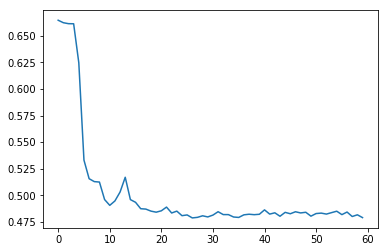

In [14]:
plt.plot(training_losses) # when num_len = 4, state_size = 16

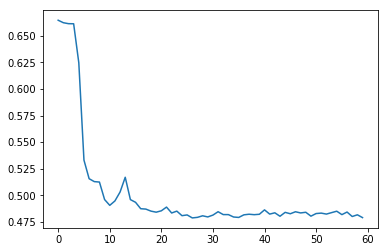

In [15]:
plt.plot(training_losses) # when num_len = 10, state_size = 16

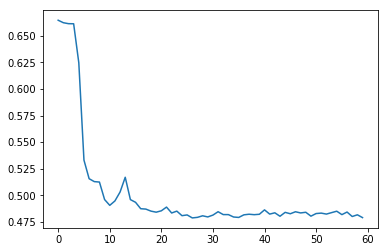

In [16]:
plt.plot(training_losses) # when num_len = 5

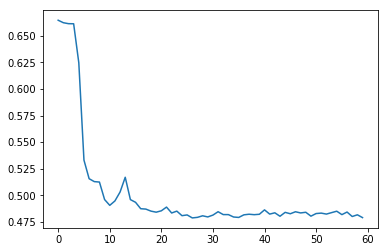

In [17]:
plt.plot(training_losses)

# 训练结束后，

## 调用tensor, 查看tensor的数值


错误案例1

In [18]:
# You must feed a value for placeholder tensor 'input_placeholder' with dtype int32 and shape [200,5]
with tf.Session() as sess:
    test = tf.get_default_graph().get_tensor_by_name("unstack:4")
    x_test = sess.run(test)

KeyError: "The name 'unstack:4' refers to a Tensor which does not exist. The operation, 'unstack', exists but only has 4 outputs."

## 调用变量，查看变量的数值

错误案例1

In [19]:
W_softmax1 = [v for v in tf.global_variables() if v.name=="softmax/W:0"][0]

with tf.variable_scope('softmax', reuse=True):
        W_softmax2 = tf.get_variable('W', [state_size, num_classes])

assert W_softmax1 is W_softmax2
print(W_softmax1.name)

softmax/W:0


In [20]:
# Attempting to use uninitialized value softmax/W
with tf.Session() as sess:
    sess.run(W_softmax1.value())

FailedPreconditionError: Attempting to use uninitialized value softmax/W
	 [[Node: softmax/W/read = Identity[T=DT_FLOAT, _class=["loc:@softmax/W"], _device="/job:localhost/replica:0/task:0/cpu:0"](softmax/W)]]

Caused by op 'softmax/W/read', defined at:
  File "/Users/yuleinku/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yuleinku/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-417b602b2d57>", line 9, in <module>
    W = tf.get_variable('W', [state_size, num_classes])
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/yuleinku/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value softmax/W
	 [[Node: softmax/W/read = Identity[T=DT_FLOAT, _class=["loc:@softmax/W"], _device="/job:localhost/replica:0/task:0/cpu:0"](softmax/W)]]


错误案例1

In [ ]:
# RuntimeError: Attempted to use a closed Session.
with tf.variable_scope('softmax', reuse=True):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes])
    xW, xb = sess.run([W, b])